from thesis_figures/Fig4_0

In [2]:
user_name = 'shayneufeld'

In [5]:
import sys
sys.path.append('/Users/{}/GitHub/mouse_bandit/data_preprocessing_code'.format(user_name))
sys.path.append('/Users/{}/GitHub/mouse_bandit'.format(user_name))
import support_functions as sf
import numpy as np
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
record = pd.read_csv('/Users/{}/GitHub/mouse_bandit/celia_session_record.csv'.format(user_name),index_col=0)

In [7]:
record.shape

(519, 18)

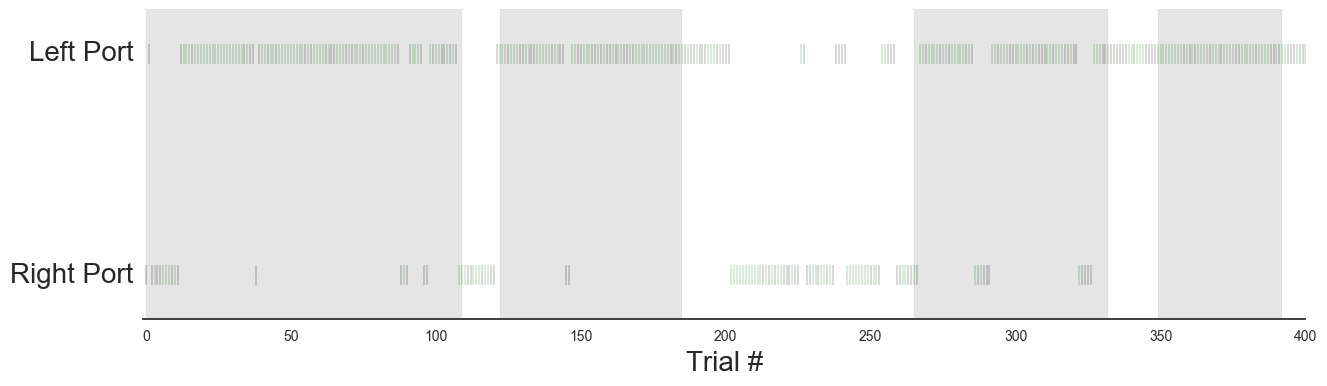

In [8]:
# for plotting a single tria's events
columns = ['Elapsed Time (s)', 'Since last trial (s)', 'Trial Duration (s)', 'Port Poked', 'Right Reward Prob', 'Left Reward Prob', 'Reward']
data = pd.read_csv('/Users/{}/GitHub/mouse_bandit/data/trial_data/10202017_Mustard_trials.csv'.format(user_name), names=columns)

block_start_trials = np.where(np.abs(np.diff(data['Right Reward Prob'].values))!=0)
block_start_times = data['Elapsed Time (s)'].values[block_start_trials[0]]
num_trials = data.shape[0]
sns.set_style('white')
ax = plt.figure(figsize=(15,4))
# shading by blocks
block_colors = ['white', 'black']
starting_side = data['Right Reward Prob'][0] > data['Left Reward Prob'][0] # 1 if right, 0 if left
plt.axvspan(0,block_start_trials[0][0], alpha=0.1, color='black');#color=block_colors[starting_side])
for i in range(len(block_start_trials[0])-1):
    plt.axvspan(block_start_trials[0][i], block_start_trials[0][i+1], alpha=0.1, color=block_colors[(i+2)%2])
#plt.vlines(block_start_trials,ymin=0,ymax=3,linestyle='dotted')
plt.scatter(data[data['Reward'] == 0].index.values[:num_trials],
            data[data['Reward'] == 0]['Port Poked'].values[:num_trials],color='black',s=200,alpha=0.8, marker='|')
plt.scatter(data[data['Reward'] == 1].index.values[:num_trials],
            data[data['Reward'] == 1]['Port Poked'].values[:num_trials],color='green',s=200,alpha=0.8, marker='|')
plt.xticks(np.arange(0,num_trials,50))#list(map(int,np.arange(0,1700/60))),fontsize=20)
plt.yticks([1,2],['Right Port','Left Port'],fontsize=20)
plt.xlim(-1,400)
#plt.xlim(-1, num_trials+1)
plt.xlabel('Trial #',fontsize=20)
plt.ylim(0.8,2.2)
sns.despine(left=True)
#fig_name = '/Users/shayneufeld/Dropbox/Thesis/CHPT4/Figures/singlesession.eps'
#plt.savefig(fig_name, format='eps', dpi=1000)


### Load in data and track performance for mice across days
    mice = numpy, names of all mice included in analysis
    x = numpy, number of days plotted
    y_temp = subset of data - probability mouse chose high port at designated reward probability condition
    y = numpy, fraction high port chosen in past x days for given condition

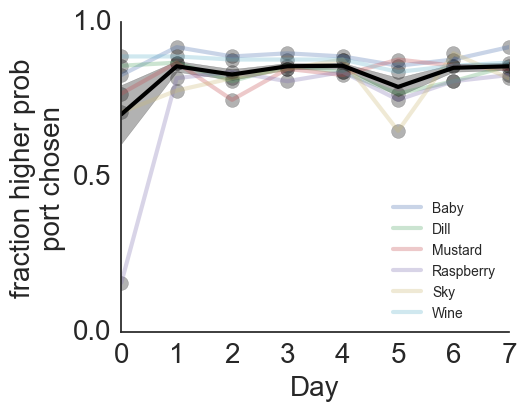

In [9]:
mice = np.unique(record['Mouse ID'].values) # get names of all mice in record

sns.set_style('white')
plt.figure(figsize=(5,4))

ndays = 10
highport = np.empty((mice.shape[0],ndays)) # number of mice x number of days
day = np.arange(0,ndays) # number of days to plot

k = 0 
for i,mouse in enumerate(mice):
    highport_temp = record[((record['Mouse ID'] == mouse) & ((record['Left Reward Prob'] == 0.9) | (record['Left Reward Prob'] == 0.1)))]['p(high Port)'].values
    try:
        highport[k,:] = highport_temp[-ndays:] # values of fraction high port chosen for last 10 days
        plt.plot(day,highport[k,:],label=mouse,alpha=0.3,linewidth=3)
        plt.scatter(day,highport[k,:],label=mouse,alpha=0.3,s=100,color='black')
        k+=1
    except:
        print(mouse)

plt.plot(day,highport.mean(axis=0),color='black',linewidth=3)
err = highport.std(axis=0)/np.sqrt(7)
plt.fill_between(day,y1=highport.mean(axis=0)+err,y2=highport.mean(axis=0)-err,color='black',alpha=0.3)

# figure asthetics
plt.ylim(0,1)
plt.xlim(0,7) # only plot 7 days
plt.xticks(fontsize=20)
plt.yticks([0,0.5,1],fontsize=20)
plt.xlabel('Day',fontsize=20)
plt.ylabel('fraction higher prob\nport chosen',fontsize=20)
plt.legend((mice), loc='best')
sns.despine(top='True')

### load in data frame and add ids for blocks and block lengths

In [10]:
data=pd.read_csv('/Users/{}/GitHub/mouse_bandit/data/processed_data/markov_master.csv'.format(user_name),index_col=0)
data.shape

(230819, 53)

In [11]:
data90 = pd.read_csv('/Users/{}/GitHub/mouse_bandit/data/processed_data/markov_9010.csv'.format(user_name),index_col=0)
data80 = pd.read_csv('/Users/{}/GitHub/mouse_bandit/data/processed_data/markov_8020.csv'.format(user_name),index_col=0)
data70 = pd.read_csv('/Users/{}/GitHub/mouse_bandit/data/processed_data/markov_7030.csv'.format(user_name),index_col=0)
data90['Condition'] = '90-10'
data80['Condition'] = '80-20'
data70['Condition'] = '70-30'
datas = data90.append(data80)
datas = datas.append(data70)

# add single index sequence for all rows
datas = datas.reset_index()
data=datas.copy()
data.shape

(238213, 55)

In [12]:
columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked',
           'Right Reward Prob','Left Reward Prob','Reward Given',
          'center_frame','decision_frame', 'Block ID']

for session in np.unique(data['Session ID'])[:]:
    
    # load in data from a particular session
    record[record['Session ID'] == session] # take only rows from record that match session name
    root_dir = '/Users/{}/GitHub/mouse_bandit/data/trial_data'.format(user_name)
    full_name = session + '_trials.csv'
    path_name = os.path.join(root_dir,full_name)
    trial_df = pd.read_csv(path_name,names=columns) # load in full dataset from a single trial
    
    # determine block lengths and attach block id to each trial
    # identify blocks by trials where right reward probability changes
    blocks = list(np.diff(np.concatenate((range(1),np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0]+2))))
    
    try: 
        blocks.append(int(record[record['Session ID']==session]['No. Trials'].values)
                 -np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0][-1]-1) # length of the last block at end
        block_id = np.asarray([x+1 for x in range(int(record[record['Session ID']==session]['No. Blocks'].values[0])+1)
            for y in range(blocks[x])])

        trial_df['Block ID'] = block_id[:-1] # add column in trial_df for block id
        
        # add block id and current block length to dataframe; start with 11th frame so can fill in full feature matrix
        data.loc[data[data['Session ID']==session].index, 'Block ID'] = block_id[11:]
        temp_blocks = [blocks[x-1] for x in block_id[11:]]
        data.loc[data[data['Session ID']==session].index, 'Current Block Length'] = temp_blocks
    
    except IndexError: # report any errors - days when no blocks were completed
        print('No blocks in %s' %session)

data.tail(5)

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
238208,710,Wine,12222017_Wine,721.0,43.0,21.0,23.0,-2.0,1.0,1.0,...,0.274,1.369,0.476,1.0,0.0,1.0,1.0,70-30,14.0,48.0
238209,711,Wine,12222017_Wine,722.0,44.0,22.0,24.0,1.0,1.0,0.0,...,0.476,1.690,0.224,1.0,0.0,1.0,1.0,70-30,14.0,48.0
238210,712,Wine,12222017_Wine,723.0,45.0,23.0,25.0,2.0,1.0,0.0,...,0.224,1.954,0.272,1.0,0.0,1.0,1.0,70-30,14.0,48.0
238211,713,Wine,12222017_Wine,724.0,46.0,24.0,26.0,3.0,1.0,1.0,...,0.272,1.432,0.240,1.0,0.0,1.0,1.0,70-30,14.0,48.0
238212,714,Wine,12222017_Wine,725.0,47.0,25.0,27.0,4.0,1.0,0.0,...,0.240,2.069,0.268,1.0,0.0,1.0,1.0,70-30,14.0,48.0


### select block lengths over range of interest

In [8]:
data_match_blocks = data[data['Current Block Length']<90] # take only blocks with fewer than 90 trials
data_match_blocks = data_match_blocks[data_match_blocks['Current Block Length']>50] # blocks with 30+ trials
datas = data_match_blocks.copy()

In [9]:
# some stats
print('# trials included =', datas.shape[0])

print('# sessions included =', len(np.unique(datas['Session ID'])))# sessions that contain blocks of these lengths

temp = np.diff(datas['Block ID'].values)
print('# blocks =', np.sum(np.abs(temp)>0))

print('mean block length =', np.round(np.mean(datas['Current Block Length']), decimals=2))

# trials included = 68423
# sessions included = 318
# blocks = 1021
mean block length = 69.27


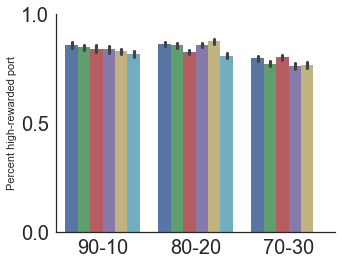

In [10]:
#ax2 = sns.barplot(x='Condition',y='Higher p port',data=datas)
plt.figure(figsize=(5,4))
ax1 = sns.barplot(x='Condition',y='Higher p port',data=datas[datas['Condition'] != '100-0'], hue='Mouse ID')

# figure asthetics
plt.yticks([0,0.5,1.0],fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Percent high-rewarded port')
plt.xlabel('')
ax1.legend_.remove()
sns.despine()

### set up some variables for calculating probability switch
    trial_stats = dataframe with mean and standard error of probability choosing high port at any position within a block
        'n' represents number of trials represented in each block position (should decrease throughout, because every block will have a trial in position 11-50 (if trimming blocks) but not every block has trial in position #90 (1-10 will have less because of building feature matrix)
        'mean' and 'sem' are dependent variables used for plotting probability switching over time
        'trial' is independent variable

In [11]:
'''
I think this was only necessary when wanting to make sure there were full 50 trial blocks?


session_ids = np.unique(datas['Session ID'].values)
block_trials_ = np.array([])
for session in session_ids:
    data = datas[datas['Session ID']==session].copy()
    block_ends = data['Trial'].values[np.where(data['Block Trial'].values==0)[0]]
    
    for trial in data.iterrows():
        try:
            block_trial = block_ends[np.where(block_ends > trial[1]['Trial'])[0][0]] - trial[1]['Block Trial']
        except:
            block_trial = 0
        block_trials_ = np.append(block_trials_,block_trial)
        
'''

"\nI think this was only necessary when wanting to make sure there were full 50 trial blocks?\n\n\nsession_ids = np.unique(datas['Session ID'].values)\nblock_trials_ = np.array([])\nfor session in session_ids:\n    data = datas[datas['Session ID']==session].copy()\n    block_ends = data['Trial'].values[np.where(data['Block Trial'].values==0)[0]]\n    \n    for trial in data.iterrows():\n        try:\n            block_trial = block_ends[np.where(block_ends > trial[1]['Trial'])[0][0]] - trial[1]['Block Trial']\n        except:\n            block_trial = 0\n        block_trials_ = np.append(block_trials_,block_trial)\n        \n"

In [12]:
# these stats show the mean probability of switching for each trial position
# for plotting trials forward from the block switch

block_trials = np.unique(datas['Block Trial'].values) # all possible positions within a block (0 to len(longest block))
conditions = np.unique(datas['Condition'].values) # string array with condition labels
#mice = np.unique(datas.index)
highport_aggregate = np.zeros((block_trials.shape[0],2)) # length of longest block x 2 (mean and std)
trial_stats = pd.DataFrame(data=None)
for condition in conditions: # because we're segregating by condition
        for i,trial in enumerate(block_trials): # for each position in a block
            data_temp = datas[datas['Condition']==condition] # take only data for one condition
            #d = d[d['Mouse ID']==mouse] # could instead take only data for one mouse
            data_matched_position= data_temp[data_temp['Block Trial']==trial] # dataset for ALL instances where block position matches (say, 5th trial in every block)
            '''
            boolean = (((datas['Block Trial'] == trial) 
                    & (datas['Condition']==condition))
                    & (datas['Mouse ID'] == mouse))
            
            t = datas[boolean]['Higher p port'].values
            '''
            highport_trial = data_matched_position['Higher p port'].values # all values for p(highport) for block position-matched trials
            highport_aggregate[i,0] = highport_trial.mean() # mean for summary of p(highport) at this block position
            highport_aggregate[i,1] = highport_trial.std()/np.sqrt(highport_trial.shape[0])

            data_temp = {'Condition':condition,'trial':trial,
                 'mean':highport_trial.mean(),'sem':highport_trial.std()/np.sqrt(highport_trial.shape[0]),'n':highport_trial.shape[0]}
            trial_stats = trial_stats.append(pd.DataFrame(data=data_temp,index=[0]))

In [27]:
trial_stats.tail()

,Condition,mean,n,sem,trial
0,90-10,0.900000,20,0.067082,84.0
0,90-10,0.866667,15,0.087771,85.0
0,90-10,0.800000,10,0.126491,86.0
0,90-10,0.833333,6,0.152145,87.0
0,90-10,1.000000,3,0.000000,88.0


In [29]:
datas['Block Trial Rev'] = (datas['Block Trial'].values+1) - datas['Current Block Length'].values
# add one because block trial starts at 0

In [31]:
# for plotting trials backward from the block switch

block_trials_rev = np.unique(datas['Block Trial Rev'].values)
conditions = np.unique(datas['Condition'].values)
p = np.zeros((block_trials_rev.shape[0],2))
trial_stats_ = pd.DataFrame(data=None)

for condition in conditions:
    for i,trial in enumerate(block_trials_rev):
        t = datas[((datas['Block Trial Rev'] == trial) 
                   & (datas['Condition']==condition))]['Higher p port'].values
        p[i,0] = t.mean()
        p[i,1] = t.std()/np.sqrt(t.shape[0])
    
        d = {'Condition':condition,'trial':trial,'mean':t.mean(),'sem':t.std()/np.sqrt(t.shape[0]),'n':t.shape[0]}
        trial_stats_ = trial_stats_.append(pd.DataFrame(data=d,index=[0]))
        
#trial_stats_['trial'] = trial_stats_['trial']*-1


/Users/celia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/Users/celia/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/celia/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/celia/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/celia/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/celia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


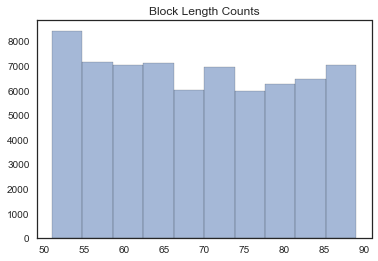

In [33]:
# need to scale this by block size so longer blocks aren't overexaggerated just by having more trials in them? worth 
# looking at both ways
plt.hist(datas['Current Block Length'], histtype='bar', alpha=0.5, ec='black')
plt.title('Block Length Counts')

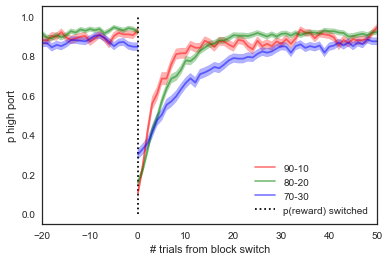

In [34]:
trial_stats = trial_stats[trial_stats['n'] > 30] # if there are sufficient repetitions of this block position
trial_stats_ = trial_stats_[trial_stats_['n'] > 30]

colors = ['red','green','blue','purple']
conditions=['90-10','80-20', '70-30']

for i,condition in enumerate(conditions):
    trial_stat = trial_stats[trial_stats['Condition']==condition]
    trial_stat_ = trial_stats_[trial_stats_['Condition']==condition]
    u = trial_stat['mean'].values
    err = trial_stat['sem'].values
    trial_pos = trial_stat['trial'].values
    
    u_ = trial_stat_['mean'].values
    err_ = trial_stat_['sem'].values
    trial_pos_ = trial_stat_['trial'].values
    
    plt.plot(trial_pos,u,color=colors[i],alpha=0.5,label=condition)
    plt.fill_between(trial_pos,y1=u-err,y2=u+err,color=colors[i],alpha=0.3)
    
    plt.plot(trial_pos_,u_,color=colors[i],alpha=0.5)
    plt.fill_between(trial_pos_,y1=u_-err_,y2=u_+err_,color=colors[i],alpha=0.3)
    
plt.vlines(x=0,ymin=0,ymax=1,linestyle='dotted',label='p(reward) switched')

plt.xlim(-20,50)
plt.legend(loc='lower right')
plt.xlabel('# trials from block switch')
plt.ylabel('p high port')

In [35]:
# calculate baseline p(highport) to compare with after block switch for each condition

conditions = ['90-10', '80-20', '70-30']
u_avg_ = np.zeros(3)
err_avg_ = np.zeros(3)
for i,condition in enumerate(conditions):
    trials = trial_stats_[((trial_stats_['trial'] > -15) 
                           & (trial_stats_['trial'] < 0)
                           & (trial_stats_['Condition']==condition))]
    
    u_avg_[i] = trials['mean'].mean() # mean p(highport) for 15 trials preceding block switch ~baseline
    err_avg_[i] = np.sqrt(np.sum(trials['sem'].values**2) / (trials.shape[0]-1))

In [51]:
np.where(u >= u_avg_[2]) # where is mean p(highport) greater than baseline for 70-30

(array([48, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
        73, 74, 75, 79, 81, 84, 85]),)

In [52]:
stats = pd.DataFrame()
for c in conditions:
    for mouse in mice:
        d = datas[((datas['Condition'] == c) & (datas['Mouse ID'] == mouse))]
        if (d['Session ID'].unique().shape[0] > 1):
            s = bp.extract_session_stats(d)
            s['mouse'] = mouse
            s['condition'] = c
            s['n_trials'] = d.shape[0]
            s['n_sessions'] = d['Session ID'].unique().shape[0]
            stats = stats.append(s)

In [38]:
#all the block numbers
data = d.copy()
t_block_unique = np.unique(data['Block Trial'].astype(int))

    # initialize matrix for p(switch) at every trial number in block. 2nd column for SEM
p_switch_block = np.zeros((t_block_unique.shape[0],2))

    # initialize matrix for p(high_p_port)
high_p_port = np.zeros_like(p_switch_block)

'''
calculate p(switch) for each trial # in block (from 0 -> end)
'''
for t in t_block_unique:
    switches = data[data['Block Trial'] == t]['Switch']
    p_switch_block[t,0] = switches.mean(axis=0)
    p_switch_block[t,1] = switches.std(axis=0) / np.sqrt(switches.shape[0])
        
    highport = data[data['Block Trial']==t]['Higher p port']
    high_p_port[t,0] = highport.mean(axis=0)
    high_p_port[t,1] = highport.std(axis=0) / np.sqrt(highport.shape[0])


'''
calculate p(switch) and p(high port) for trial #s in block (from -L to +L)
'''

data.index = np.arange(data.shape[0]) # <-- this is important
switch_points = data[data['Block Trial'] == 0].index.values

L = 30
paraswitch = np.zeros((switch_points.shape[0],L*2 + 1))
paraswitch_port = np.zeros_like(paraswitch)

for i,point in enumerate(switch_points):
    try:
        paraswitch[i,:] = data.iloc[point-L:point+L+1]['Switch']
        paraswitch_port[i,:] = data.iloc[point-L:point+L+1]['Higher p port']
    except:
        pass

ValueError: Invalid RGBA argument: 0.33333333333333331

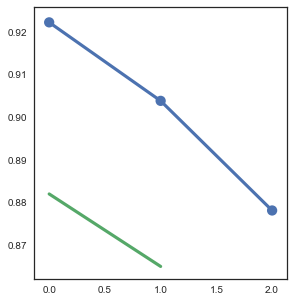

In [39]:
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.pointplot(x='condition',y='stable_phigh',hue='mouse',data=stats)
plt.legend(bbox_to_anchor=(1.5,1))
plt.ylim(0.5,1.05)
plt.title('stable fraction better port chosen')

plt.subplot(122)
sns.boxplot(x='condition',y='stable_phigh',data=stats)
sns.swarmplot(x='condition',y='stable_phigh',data=stats,color='.25')
plt.legend(bbox_to_anchor=(1.5,1))
plt.ylim(0.5,1.05)
plt.title('stable fraction better port chosen')

ValueError: Invalid RGBA argument: 0.33333333333333331

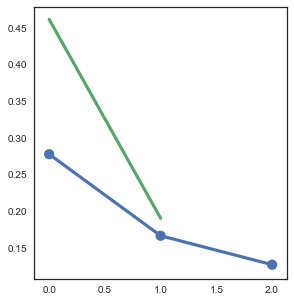

In [40]:
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.pointplot(x='condition',y='peak_pswitch',hue='mouse',data=stats)
plt.legend(bbox_to_anchor=(1.5,1))
plt.ylim(0,.5)
plt.title('peak fraction switch trials following block switch')

plt.subplot(122)
sns.boxplot(x='condition',y='peak_pswitch',data=stats)
sns.swarmplot(x='condition',y='peak_pswitch',data=stats,color='.25')
plt.legend(bbox_to_anchor=(1.5,1))
plt.ylim(0,.5)
plt.title('peak fraction switch trials following block switch')

ValueError: Invalid RGBA argument: 0.33333333333333331

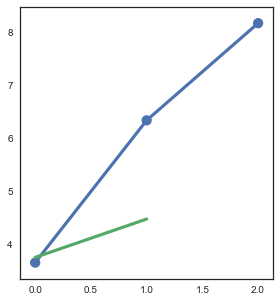

In [41]:
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.pointplot(x='condition',y='rebias_tau',hue='mouse',data=stats)
plt.legend(bbox_to_anchor=(1.5,1))
#plt.ylim(0.5,1.05)
plt.title('peak fraction switch trials following block switch')

plt.subplot(122)
sns.boxplot(x='condition',y='rebias_tau',data=stats)
sns.swarmplot(x='condition',y='rebias_tau',data=stats,color='0.25')
plt.legend(bbox_to_anchor=(1.5,1))
#plt.ylim(0.5,1.05)
plt.title('peak fraction switch trials following block switch')

([<matplotlib.axis.XTick at 0x122542320>,
 <a list of 3 Text xticklabel objects>)

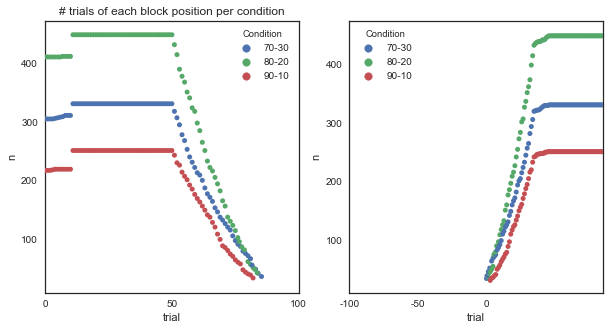

In [42]:
trial_stats = trial_stats[trial_stats['n'] > 30] # if there are sufficient repetitions of this block position
trial_stats_ = trial_stats_[trial_stats_['n'] > 30]

plt.figure(figsize=(10,5))
plt.subplot(121)
sns.swarmplot(x='trial',y='n',hue='Condition',data=trial_stats)
plt.xlim(0,100)
plt.xticks([0,50,100],[0,50,100])
plt.title('# trials of each block position per condition')

plt.subplot(122)
sns.swarmplot(x='trial',y='n',hue='Condition',data=trial_stats_)
plt.title('')
#plt.xlim(-100,0)
plt.xticks([0,-50,-100],[0,-50,-100])

In [71]:
t_block_unique = np.unique(datas['Block Trial'].values)
p_switch_block = np.zeros((t_block_unique.shape[0],2))
high_p_port = np.zeros_like(p_switch_block)
trial_block_count = np.zeros_like(t_block_unique)
#data_temp = datas[datas['Condition']=='80-20']
p_switch_block_probs = np.empty((p_switch_block.shape[0], p_switch_block.shape[1], 3))
for i,condition in enumerate(conditions):
    data_temp = datas[datas['Condition']==condition]
    for t in t_block_unique:
        t=int(t)
        p_switch_block[t,0] = data_temp[data_temp['Block Trial'] == t]['Switch'].mean(axis=0)
        trial_block_count[t] = data_temp[data_temp['Block Trial'] == t].shape[0]
        p_switch_block[t,1] = data_temp[data_temp['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[t])

        high_p_port[t,0] = data_temp[data_temp['Block Trial']==t]['Higher p port'].mean(axis=0)
        high_p_port[t,1] = data_temp[data_temp['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[t])
    p_switch_block_probs[:,:,i] = p_switch_block.copy()    

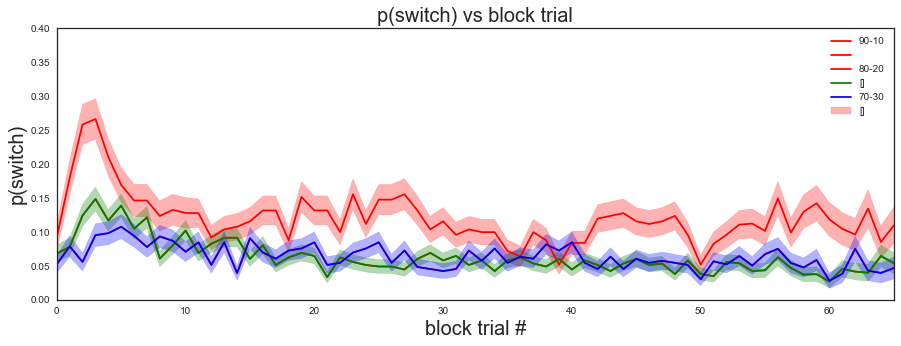

In [106]:
x_end=65
plt.figure(figsize=(15,5))

plt.plot(t_block_unique,p_switch_block_probs[:,0,:],color='red') # 90-10
plt.plot(t_block_unique,p_switch_block_probs[:,0,1],color='green') # 80-20
plt.plot(t_block_unique,p_switch_block_probs[:,0,2],color='blue') # 70-30




plt.fill_between(t_block_unique,p_switch_block_probs[:,0,0]+p_switch_block_probs[:,1,0],p_switch_block_probs[:,0,0]-p_switch_block_probs[:,1,0],color='red',alpha=0.3)

plt.fill_between(t_block_unique,p_switch_block_probs[:,0,1]+p_switch_block_probs[:,1,1],p_switch_block_probs[:,0,1]-p_switch_block_probs[:,1,1],color='green',alpha=0.3)

plt.fill_between(t_block_unique,p_switch_block_probs[:,0,2]+p_switch_block_probs[:,1,2],p_switch_block_probs[:,0,2]-p_switch_block_probs[:,1,2],color='blue',alpha=0.3)

plt.legend((conditions[0], '', conditions[1], [], conditions[2], []))
#plt.legend(loc='upper right')
plt.xlim(0,x_end)
plt.ylim(0,0.4)
plt.xlabel('block trial #',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) vs block trial',fontsize=20)


In [107]:
plt.legend?